In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("processed_kelulusan.csv")
X = df.drop("Lulus", axis=1)
y = df["Lulus"]

# split: 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)
print(X_train.shape, X_val.shape, X_test.shape)

(28, 5) (6, 5) (6, 5)


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

num_cols = X_train.select_dtypes(include="number").columns

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
], remainder="drop")

rf = RandomForestClassifier(
    n_estimators=300, max_features="sqrt",
    class_weight="balanced", random_state=42
)

pipe = Pipeline([("pre", pre), ("clf", rf)])
pipe.fit(X_train, y_train)

y_val_pred = pipe.predict(X_val)
print("Baseline RF — F1(val):", f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred, digits=3))

Baseline RF — F1(val): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     1.000     1.000         3

    accuracy                          1.000         6
   macro avg      1.000     1.000     1.000         6
weighted avg      1.000     1.000     1.000         6



In [3]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="f1_macro", n_jobs=-1)
print("CV F1-macro (train):", scores.mean(), "±", scores.std())

CV F1-macro (train): 1.0 ± 0.0


In [4]:
from sklearn.model_selection import GridSearchCV

param = {
  "clf__max_depth": [None, 12, 20, 30],
  "clf__min_samples_split": [2, 5, 10]
}

gs = GridSearchCV(pipe, param_grid=param, cv=skf,
                  scoring="f1_macro", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best_model = gs.best_estimator_
y_val_best = best_model.predict(X_val)
print("Best RF — F1(val):", f1_score(y_val, y_val_best, average="macro"))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2}
Best RF — F1(val): 1.0


F1(test): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     1.000     1.000         3

    accuracy                          1.000         6
   macro avg      1.000     1.000     1.000         6
weighted avg      1.000     1.000     1.000         6

Confusion Matrix (test):
[[3 0]
 [0 3]]
ROC-AUC(test): 1.0


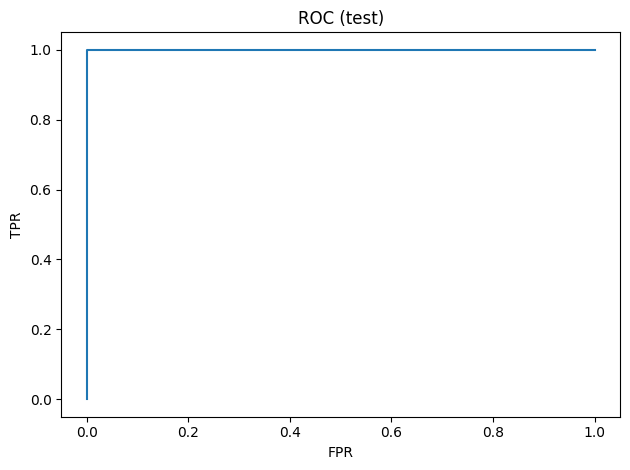

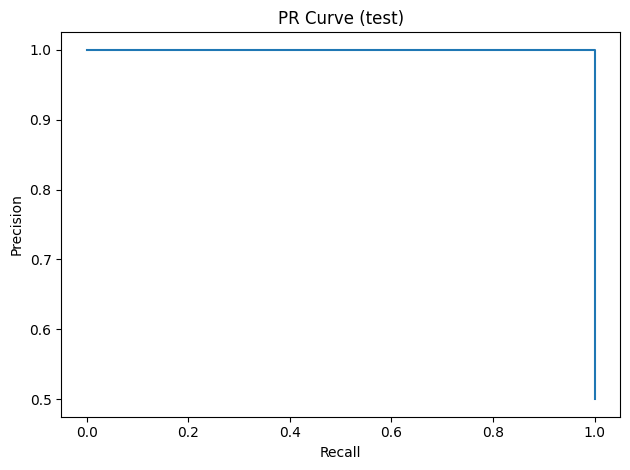

In [5]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

final_model = best_model  # pilih terbaik; jika baseline lebih baik, gunakan pipe

y_test_pred = final_model.predict(X_test)
print("F1(test):", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred, digits=3))
print("Confusion Matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

# ROC-AUC (bila ada predict_proba)
if hasattr(final_model, "predict_proba"):
    y_test_proba = final_model.predict_proba(X_test)[:,1]
    try:
        print("ROC-AUC(test):", roc_auc_score(y_test, y_test_proba))
    except:
        pass
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
    plt.tight_layout(); plt.savefig("roc_test.png", dpi=120)

    prec, rec, _ = precision_recall_curve(y_test, y_test_proba)
    plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve (test)")
    plt.tight_layout(); plt.savefig("pr_test.png", dpi=120)

In [6]:
# 6a) Feature importance native (gini)
try:
    import numpy as np
    importances = final_model.named_steps["clf"].feature_importances_
    fn = final_model.named_steps["pre"].get_feature_names_out()
    top = sorted(zip(fn, importances), key=lambda x: x[1], reverse=True)
    print("Top feature importance:")
    for name, val in top[:10]:
        print(f"{name}: {val:.4f}")
except Exception as e:
    print("Feature importance tidak tersedia:", e)

# 6b) (Opsional) Permutation Importance
# from sklearn.inspection import permutation_importance
# r = permutation_importance(final_model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
# ... (urutkan dan laporkan)

Top feature importance:
num__IPK: 0.2981
num__Waktu_Belajar_Jam: 0.2789
num__IPK_x_Study: 0.2700
num__Rasio_Absensi: 0.0918
num__Jumlah_Absensi: 0.0613


In [7]:
import joblib
joblib.dump(final_model, "rf_model.pkl")
print("Model disimpan sebagai rf_model.pkl")

Model disimpan sebagai rf_model.pkl


In [8]:
# Contoh sekali jalan (input fiktif), sesuaikan nama kolom:
import pandas as pd, joblib
mdl = joblib.load("rf_model.pkl")
sample = pd.DataFrame([{
  "IPK": 3.4,
  "Jumlah_Absensi": 4,
  "Waktu_Belajar_Jam": 7,
  "Rasio_Absensi": 4/14,
  "IPK_x_Study": 3.4*7
}])
print("Prediksi:", int(mdl.predict(sample)[0]))

Prediksi: 1


In [9]:
import pandas as pd
import joblib

In [10]:
# baca dataset yang sudah diproses
data = pd.read_csv("processed_kelulusan.csv")
print(data.head())

   IPK  Jumlah_Absensi  Waktu_Belajar_Jam  Lulus  Rasio_Absensi  IPK_x_Study
0  3.8               3                 10      1       0.214286         38.0
1  2.5               8                  5      0       0.571429         12.5
2  3.4               4                  7      1       0.285714         23.8
3  2.1              12                  2      0       0.857143          4.2
4  3.9               2                 12      1       0.142857         46.8


In [11]:
# load model Random Forest yang sudah dilatih
rf_model = joblib.load("rf_model.pkl")
print("Model berhasil dimuat:", type(rf_model))

Model berhasil dimuat: <class 'sklearn.pipeline.Pipeline'>


In [12]:
# target (label) biasanya 'Lulus'
X = data.drop("Lulus", axis=1)
y = data["Lulus"]

In [13]:
y_pred = rf_model.predict(X)

print("Hasil Prediksi (5 data pertama):", y_pred[:5])

Hasil Prediksi (5 data pertama): [1 0 1 0 1]


In [14]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y, y_pred)
print("Akurasi pada dataset penuh:", acc)

Akurasi pada dataset penuh: 1.0


In [1]:
# === LANGKAH 0: Import Library ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score, precision_score, recall_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
)

import joblib

# === LANGKAH 1: Muat Data ===
df = pd.read_csv("processed_kelulusan.csv")
X = df.drop("Lulus", axis=1)
y = df["Lulus"]

# Split data 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

num_cols = X_train.select_dtypes(include="number").columns

# Preprocessing pipeline
pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols)
], remainder="drop")

Train: (28, 5) Val: (6, 5) Test: (6, 5)


In [2]:
# === LANGKAH 2: Baseline Model (Decision Tree) ===
dt = DecisionTreeClassifier(random_state=42)

pipe_dt = Pipeline([("pre", pre), ("clf", dt)])
pipe_dt.fit(X_train, y_train)

y_val_pred_dt = pipe_dt.predict(X_val)

print("=== BASELINE: Decision Tree ===")
print("Precision:", precision_score(y_val, y_val_pred_dt, average="macro"))
print("Recall   :", recall_score(y_val, y_val_pred_dt, average="macro"))
print("F1       :", f1_score(y_val, y_val_pred_dt, average="macro"))
print(classification_report(y_val, y_val_pred_dt, digits=3))


=== BASELINE: Decision Tree ===
Precision: 1.0
Recall   : 1.0
F1       : 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     1.000     1.000         3

    accuracy                          1.000         6
   macro avg      1.000     1.000     1.000         6
weighted avg      1.000     1.000     1.000         6



In [3]:
# === LANGKAH 3: Random Forest + GridSearch ===
rf = RandomForestClassifier(
    n_estimators=300, max_features="sqrt", class_weight="balanced", random_state=42
)

pipe_rf = Pipeline([("pre", pre), ("clf", rf)])

param = {
    "clf__max_depth": [None, 12, 20, 30],
    "clf__min_samples_split": [2, 5, 10]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(pipe_rf, param_grid=param, cv=skf,
                  scoring="f1_macro", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("Best Params:", gs.best_params_)

best_model = gs.best_estimator_
y_val_pred_rf = best_model.predict(X_val)

print("\n=== RANDOM FOREST (Best) ===")
print("Precision:", precision_score(y_val, y_val_pred_rf, average="macro"))
print("Recall   :", recall_score(y_val, y_val_pred_rf, average="macro"))
print("F1       :", f1_score(y_val, y_val_pred_rf, average="macro"))
print(classification_report(y_val, y_val_pred_rf, digits=3))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'clf__max_depth': None, 'clf__min_samples_split': 2}

=== RANDOM FOREST (Best) ===
Precision: 1.0
Recall   : 1.0
F1       : 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     1.000     1.000         3

    accuracy                          1.000         6
   macro avg      1.000     1.000     1.000         6
weighted avg      1.000     1.000     1.000         6




=== EVALUASI TEST SET ===
Precision: 1.0
Recall   : 1.0
F1       : 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     1.000     1.000         3

    accuracy                          1.000         6
   macro avg      1.000     1.000     1.000         6
weighted avg      1.000     1.000     1.000         6



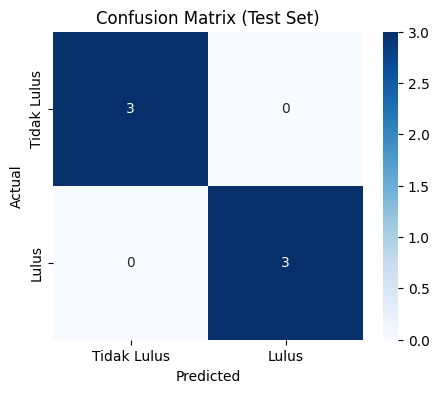

ROC-AUC: 1.0


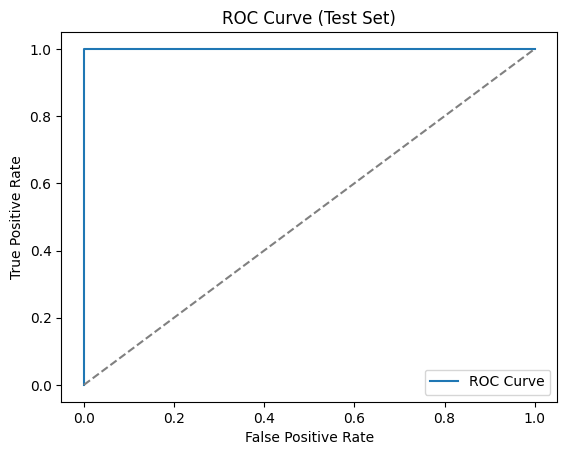

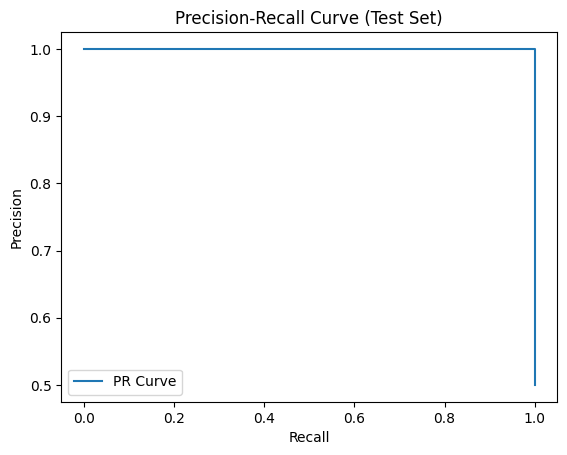

In [4]:
# === LANGKAH 4: Evaluasi Akhir di Test Set ===
final_model = best_model  # gunakan model terbaik hasil tuning
y_test_pred = final_model.predict(X_test)

print("\n=== EVALUASI TEST SET ===")
print("Precision:", precision_score(y_test, y_test_pred, average="macro"))
print("Recall   :", recall_score(y_test, y_test_pred, average="macro"))
print("F1       :", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Tidak Lulus","Lulus"], yticklabels=["Tidak Lulus","Lulus"])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC & PR Curve
if hasattr(final_model.named_steps["clf"], "predict_proba"):
    y_test_proba = final_model.predict_proba(X_test)[:,1]
    print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test Set)")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(y_test, y_test_proba)
    plt.figure()
    plt.plot(rec, prec, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Test Set)")
    plt.legend()
    plt.show()



Top 3 Features:
                  Feature  Importance
0                num__IPK    0.298078
2  num__Waktu_Belajar_Jam    0.278873
4        num__IPK_x_Study    0.270011


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13020\990790131.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(5), x="Importance", y="Feature", palette="viridis")


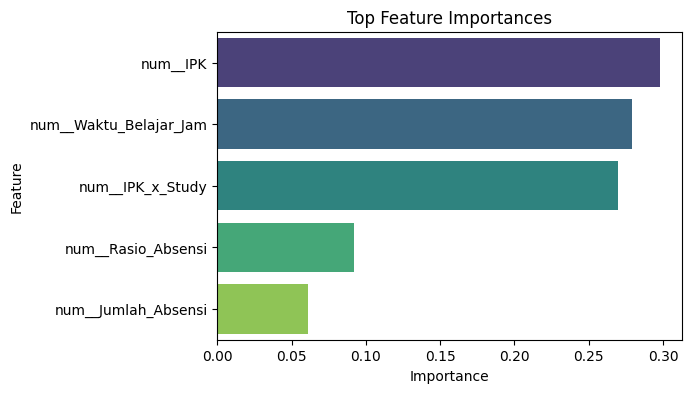

In [5]:
# === LANGKAH 5: Feature Importance ===
importances = final_model.named_steps["clf"].feature_importances_
fn = final_model.named_steps["pre"].get_feature_names_out()
feat_imp = pd.DataFrame({"Feature": fn, "Importance": importances}).sort_values("Importance", ascending=False)

print("\nTop 3 Features:")
print(feat_imp.head(3))

plt.figure(figsize=(6,4))
sns.barplot(data=feat_imp.head(5), x="Importance", y="Feature", palette="viridis")
plt.title("Top Feature Importances")
plt.show()


In [6]:
# === LANGKAH 6: Simpan Model ===
joblib.dump(final_model, "rf_model.pkl")
print("Model terbaik disimpan sebagai rf_model.pkl")


Model terbaik disimpan sebagai rf_model.pkl
